# Image Classification
In this project, we'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. We'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  We'll get to use max pooling, dropout, and fully connected layers.  At the end, we'll get to see the neural network's predictions on the sample images.

## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent our machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck



Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 12:
Image - Min Value: 20 Max Value: 207
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


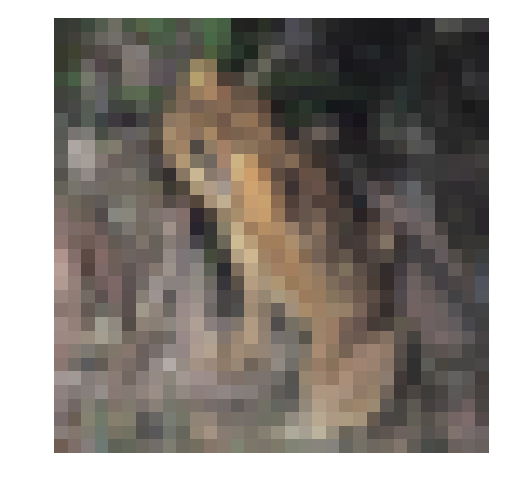

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 2
sample_id = 12
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, the `normalize` function takes in image data, `x`, and returns it as a normalized Numpy array. The values are in the range of 0 to 1, inclusive.  The return object is the same shape as `x`.

In [5]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    norm=np.linalg.norm(x)
    if norm==0: 
        return x
    
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))
    #return x/norm
   


### One-hot encode
The input, `x`, are a list of labels. The function returns the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function returns the same encoding for each value between each call to `one_hot_encode`.  Make sure to save the map of encodings outside the function.


In [6]:
from sklearn import preprocessing
onehot = preprocessing.LabelBinarizer()
onehot.fit(np.array([[0,0,0,0,0,0,0,0,0,0]]))

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    global onehot
    
    x = onehot.transform(x)
    x = x.astype(np.float32)
    return x


## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [7]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point

In [8]:

import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, we'll build each layer into a function. This makes testing a lot easier.


In [9]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    x = tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], image_shape[2]], name = "x")
    
    return x


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    
    labels = tf.placeholder(tf.float32, [None, n_classes], name = "y")
    
    return labels


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    
    return tf.placeholder(tf.float32, None, name = "keep_prob")



tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, we implement the function `conv2d_maxpool` to apply convolution then max pooling:


In [10]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :-param x_tensor: TensorFlow Tensor
    :-param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :-param conv_strides: Stride 2-D Tuple for convolution
    :-param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    
    import math
    
    h_in =  int(x_tensor.shape[1])
    w_in =  int(x_tensor.shape[2])
    h = math.ceil(float(h_in - conv_strides[0] + 1) / float(conv_strides[0]))
    w = math.ceil(float(w_in - conv_strides[1] + 1) / float(conv_strides[1]))
    
    
    weights = tf.Variable(tf.random_normal([*conv_ksize, int(x_tensor.shape[3]), conv_num_outputs], mean=0.0, stddev=0.01, dtype=tf.float32))  
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    c_strides = [1, conv_strides[0], conv_strides[1], 1]
    p_strides = [1, pool_strides[0], pool_strides[1], 1]
    p_ksize = [1, pool_ksize[0], pool_ksize[1], 1]
    padding = "SAME"
    
    
    conv = tf.nn.conv2d(tf.to_float(x_tensor), weights, c_strides, padding)
    conv = tf.nn.bias_add(conv, bias)
    #conv = tf.nn.relu(conv)
    conv = tf.nn.max_pool(conv, ksize = p_ksize , strides = p_strides, padding = padding)
    
    
    
    return conv 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer

In [11]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    
    shape = x_tensor.get_shape().as_list()        # a list: [None, 10, 30, 6]
    dim = np.prod(shape[1:])            # dim = prod(10,30,6) = 10*30*6
    x2 = tf.reshape(x_tensor, [-1, dim])           # -1 means "all"
    
    return x2


tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer

In [12]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """ 
    
    #conv = tf.contrib.layers.fully_connected(inputs = x_tensor, num_outputs = num_outputs, activation_fn = None)
    weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), num_outputs], mean=0.0, stddev=0.01))

    bias = tf.Variable(tf.zeros([num_outputs]))

    layer = tf.add(tf.matmul(x_tensor, weights), bias)

    layer = tf.nn.relu(layer)
    
    return layer


tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer

In [14]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), num_outputs], mean=0.0, stddev=0.01))

    bias = tf.Variable(tf.zeros([num_outputs]))


    output = tf.add(tf.matmul(x_tensor, weights), bias)
    
    return output 


tests.test_output(output)

Tests Passed


### Create Convolutional Model 

In [15]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    conv_num_outputs = 10
    conv_ksize = (3,3)
    conv_strides = (1,1)
    pool_ksize = (2,2)
    pool_strides = (2,2)
    
    conv1 = conv2d_maxpool(x, 32, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv2 = conv2d_maxpool(conv1, 64, conv_ksize, conv_strides, pool_ksize, pool_strides)

    flat = flatten(conv2)
    
    num_outputs = 512
    fullycon1 = fully_conn(flat, num_outputs)
    dropout = tf.nn.dropout(fullycon1, tf.to_float(keep_prob))
    
    num_outputs = 10
    outputs = output(dropout, num_outputs)
    
    return outputs


##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network

In [17]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict = {x:feature_batch, y: label_batch, keep_prob: keep_probability})
    
    
tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats

In [19]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    
    loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.0})
    valid_acc = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0})
    print('Loss: {:>10.4f} Accuracy: {:.6f}'.format(loss,valid_acc))

### Hyperparameters

In [20]:
epochs = 4
batch_size = 64
keep_probability = .6



### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. Once the final validation accuracy is 50% or greater, we'll run the model on all the data in the next section.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.0554 Accuracy: 0.370200
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.7304 Accuracy: 0.439400
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.5567 Accuracy: 0.479400
Epoch  4, CIFAR-10 Batch 1:  Loss:     1.3254 Accuracy: 0.512200


### Fully Train the Model
Now that we've got a good accuracy with a single CIFAR-10 batch, we'll try it with all five batches.

In [22]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.0143 Accuracy: 0.392600
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.5982 Accuracy: 0.458000
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.3435 Accuracy: 0.482400
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.2446 Accuracy: 0.519200
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.3183 Accuracy: 0.545200
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.3896 Accuracy: 0.555800
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.1224 Accuracy: 0.573400
Epoch  2, CIFAR-10 Batch 3:  Loss:     0.9481 Accuracy: 0.579000
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.0173 Accuracy: 0.621800
Epoch  2, CIFAR-10 Batch 5:  Loss:     0.8847 Accuracy: 0.613600
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.0444 Accuracy: 0.619200
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.8550 Accuracy: 0.655000
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.6903 Accuracy: 0.638200
Epoch  3, CIFAR-10 Batch 4:  Loss:     0.7967 Accuracy: 0.658800
Epoch  3, CIFAR-10 Batch 5:  Loss:     0.6619 Accuracy: 0.658200
Epoch  4, CIF

# Checkpoint
The model has been saved to disk.

## Test Model
Test your model against the test dataset. 

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6842157643312102



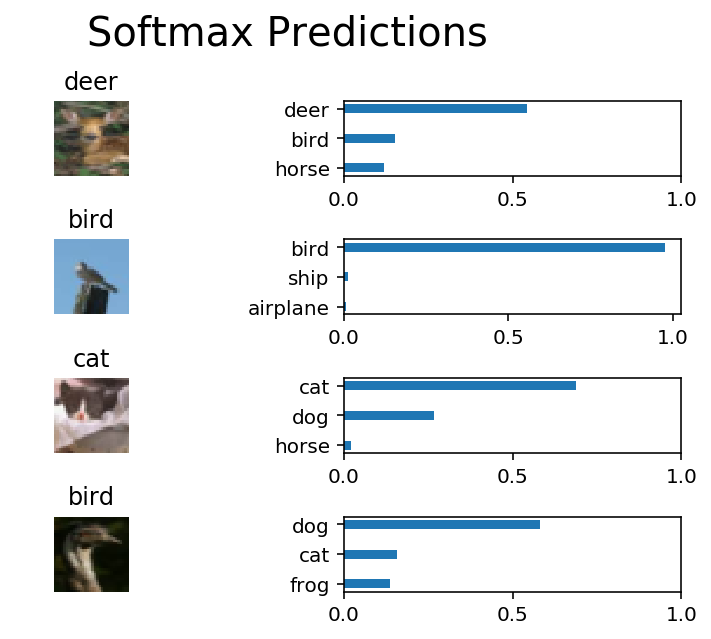

In [59]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()